In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [2]:
margin = 1

# Загружаем данные

In [3]:
buy_patterns = np.load('data/buy_patterns.npy')

In [4]:
buy_patterns_clusters = np.load('data/buy_patterns_clusters.npy')

In [5]:
buy_patterns_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [6]:
sell_patterns = np.load('data/sell_patterns.npy')

In [7]:
sell_patterns_clusters = np.load('data/sell_patterns_clusters.npy')

In [8]:
sell_patterns_clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

In [9]:
shift_sell_patterns_clusters = sell_patterns_clusters + 2
shift_sell_patterns_clusters

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int64)

# Объединяем датасеты

In [21]:
patterns = np.concatenate((buy_patterns, sell_patterns), axis=0)
patterns = np.float32(patterns)

In [34]:
patterns.shape

torch.Size([55, 60, 5])

In [22]:
patterns_clusters = np.concatenate((buy_patterns_clusters, shift_sell_patterns_clusters), axis=0)

In [23]:
patterns = torch.tensor(patterns)

In [24]:
patterns_clusters = torch.tensor(patterns_clusters)

In [25]:
dataset = TensorDataset(patterns,patterns_clusters) # create your datset

In [26]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [27]:
n_classes = 4

In [49]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax

In [46]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [47]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

C:\Program Files\Python310\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/60000 (0%)]	Loss: 2.359314	Accuracy: 7.03125
Train: [12800/60000 (21%)]	Loss: 3.318015	Accuracy: 10.393688725490197
Train: [25600/60000 (43%)]	Loss: 2.298896	Accuracy: 11.030321782178218
Train: [38400/60000 (64%)]	Loss: 2.042793	Accuracy: 15.668977649006623
Train: [51200/60000 (85%)]	Loss: 1.478488	Accuracy: 22.941930970149254

Epoch: 1/20. Train set: Average loss: 2.1125	Accuracy: 28.108333333333334
Epoch: 1/20. Validation set: Average loss: 0.9400	Accuracy: 68.22
Train: [0/60000 (0%)]	Loss: 1.054544	Accuracy: 61.328125
Train: [12800/60000 (21%)]	Loss: 0.781212	Accuracy: 74.96936274509804
Train: [25600/60000 (43%)]	Loss: 0.702644	Accuracy: 77.16584158415841
Train: [38400/60000 (64%)]	Loss: 0.587175	Accuracy: 79.15459437086092
Train: [51200/60000 (85%)]	Loss: 0.451041	Accuracy: 81.53762437810946

Epoch: 2/20. Train set: Average loss: 0.5934	Accuracy: 82.99
Epoch: 2/20. Validation set: Average loss: 0.3103	Accuracy: 93.05
Train: [0/60000 (0%)]	Loss: 0.324973	Accuracy: 91.40625

Train: [38400/60000 (64%)]	Loss: 0.017429	Accuracy: 99.6197226821192
Train: [51200/60000 (85%)]	Loss: 0.012298	Accuracy: 99.61714863184079

Epoch: 18/20. Train set: Average loss: 0.0140	Accuracy: 99.63166666666666
Epoch: 18/20. Validation set: Average loss: 0.0904	Accuracy: 98.79
Train: [0/60000 (0%)]	Loss: 0.003934	Accuracy: 100.0
Train: [12800/60000 (21%)]	Loss: 0.014076	Accuracy: 99.62469362745098
Train: [25600/60000 (43%)]	Loss: 0.013428	Accuracy: 99.63644801980197
Train: [38400/60000 (64%)]	Loss: 0.012668	Accuracy: 99.64041804635761
Train: [51200/60000 (85%)]	Loss: 0.013083	Accuracy: 99.64824315920399

Epoch: 19/20. Train set: Average loss: 0.0136	Accuracy: 99.63833333333334
Epoch: 19/20. Validation set: Average loss: 0.0907	Accuracy: 98.81
Train: [0/60000 (0%)]	Loss: 0.027124	Accuracy: 98.828125
Train: [12800/60000 (21%)]	Loss: 0.012361	Accuracy: 99.65533088235294
Train: [25600/60000 (43%)]	Loss: 0.013326	Accuracy: 99.66738861386139
Train: [38400/60000 (64%)]	Loss: 0.014817	Accur

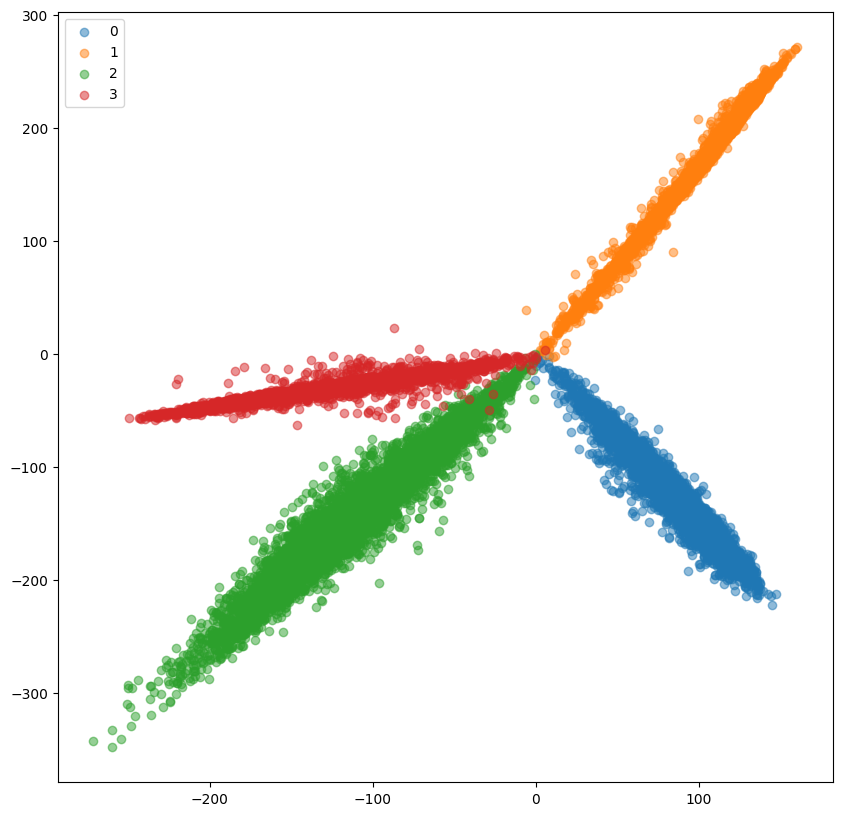

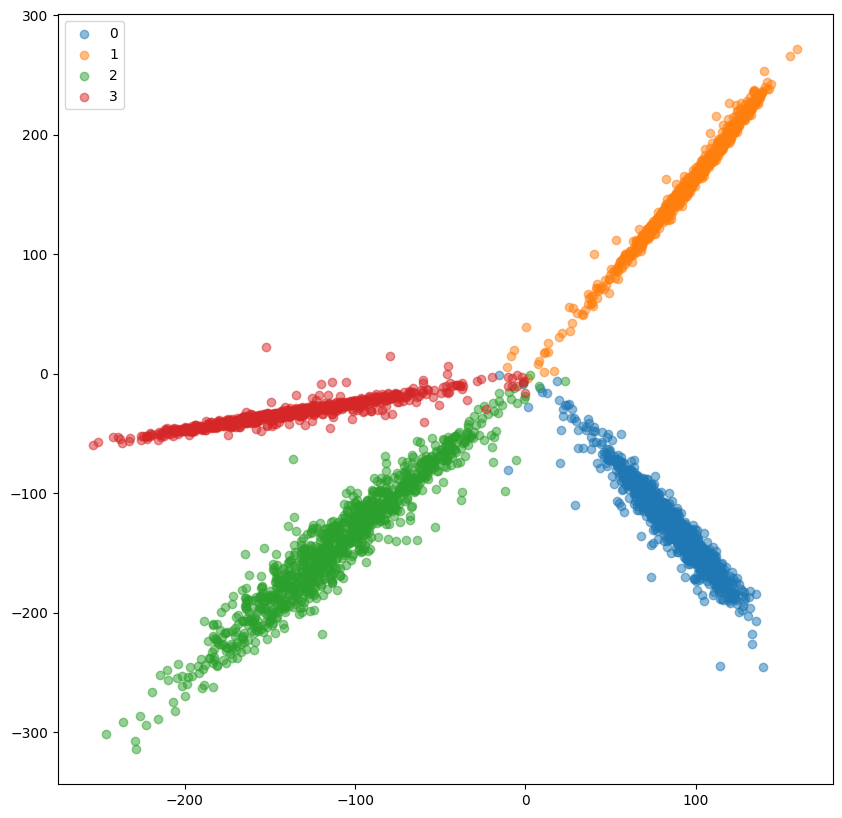

In [50]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Siamese network

In [51]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

C:\Program Files\Python310\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Program Files\Python310\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Program Files\Python310\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Program Files\Python310\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [52]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.256471
Train: [12800/60000 (21%)]	Loss: 0.063828
Train: [25600/60000 (43%)]	Loss: 0.040438
Train: [38400/60000 (64%)]	Loss: 0.029532
Train: [51200/60000 (85%)]	Loss: 0.024880

Epoch: 1/20. Train set: Average loss: 0.0372
Epoch: 1/20. Validation set: Average loss: 0.0195
Train: [0/60000 (0%)]	Loss: 0.020262
Train: [12800/60000 (21%)]	Loss: 0.017493
Train: [25600/60000 (43%)]	Loss: 0.014434
Train: [38400/60000 (64%)]	Loss: 0.013056
Train: [51200/60000 (85%)]	Loss: 0.012951

Epoch: 2/20. Train set: Average loss: 0.0142
Epoch: 2/20. Validation set: Average loss: 0.0108
Train: [0/60000 (0%)]	Loss: 0.009905
Train: [12800/60000 (21%)]	Loss: 0.011135
Train: [25600/60000 (43%)]	Loss: 0.008841
Train: [38400/60000 (64%)]	Loss: 0.008102
Train: [51200/60000 (85%)]	Loss: 0.008053

Epoch: 3/20. Train set: Average loss: 0.0088
Epoch: 3/20. Validation set: Average loss: 0.0096
Train: [0/60000 (0%)]	Loss: 0.009019
Train: [12800/60000 (21%)]	Loss: 0.007030
Train: [25600/6000

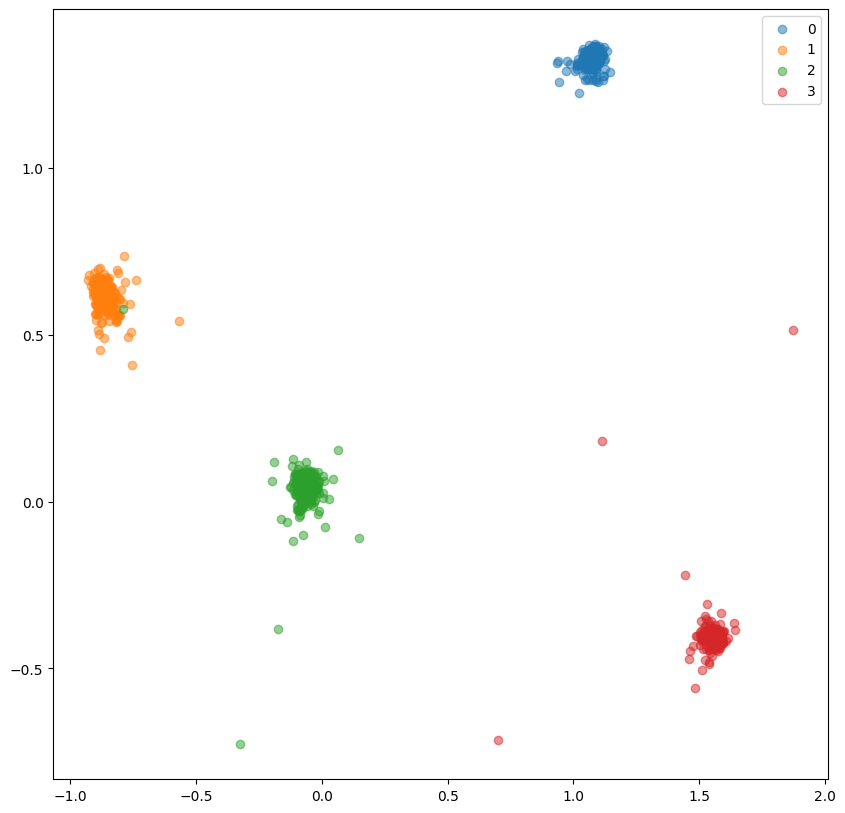

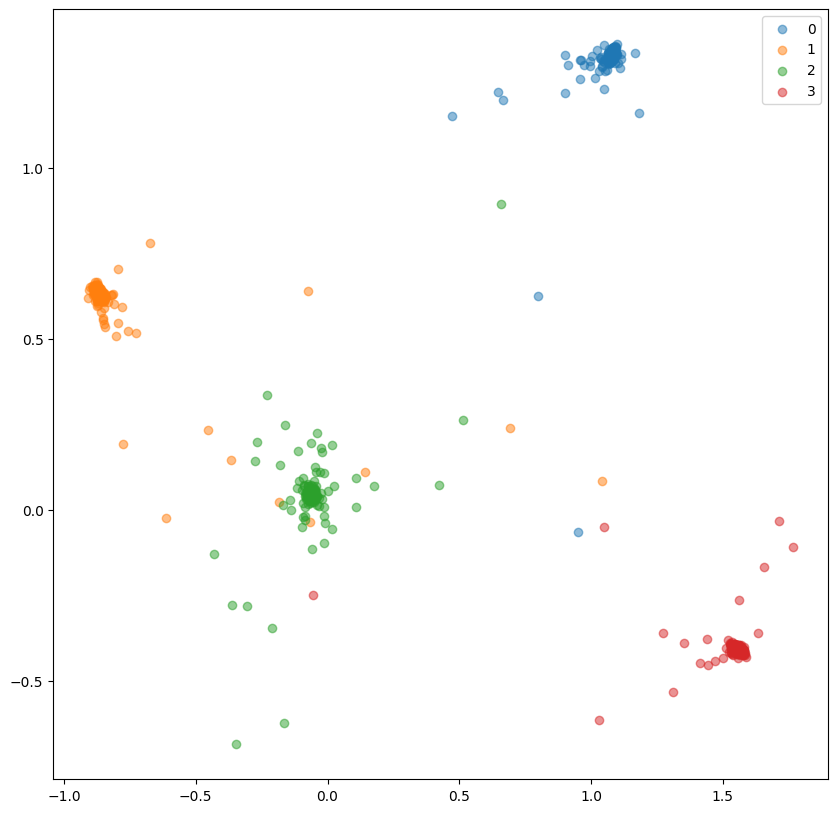

In [53]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network

In [54]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [56]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.172001
Train: [12800/60000 (21%)]	Loss: 0.114090
Train: [25600/60000 (43%)]	Loss: 0.078865
Train: [38400/60000 (64%)]	Loss: 0.065145
Train: [51200/60000 (85%)]	Loss: 0.059262

Epoch: 1/20. Train set: Average loss: 0.0765
Epoch: 1/20. Validation set: Average loss: 0.0530
Train: [0/60000 (0%)]	Loss: 0.035381
Train: [12800/60000 (21%)]	Loss: 0.046946
Train: [25600/60000 (43%)]	Loss: 0.048075
Train: [38400/60000 (64%)]	Loss: 0.040828
Train: [51200/60000 (85%)]	Loss: 0.037549

Epoch: 2/20. Train set: Average loss: 0.0417
Epoch: 2/20. Validation set: Average loss: 0.0385
Train: [0/60000 (0%)]	Loss: 0.005319
Train: [12800/60000 (21%)]	Loss: 0.035123
Train: [25600/60000 (43%)]	Loss: 0.030357
Train: [38400/60000 (64%)]	Loss: 0.026440
Train: [51200/60000 (85%)]	Loss: 0.027400

Epoch: 3/20. Train set: Average loss: 0.0290
Epoch: 3/20. Validation set: Average loss: 0.0385
Train: [0/60000 (0%)]	Loss: 0.056886
Train: [12800/60000 (21%)]	Loss: 0.029854
Train: [25600/6000

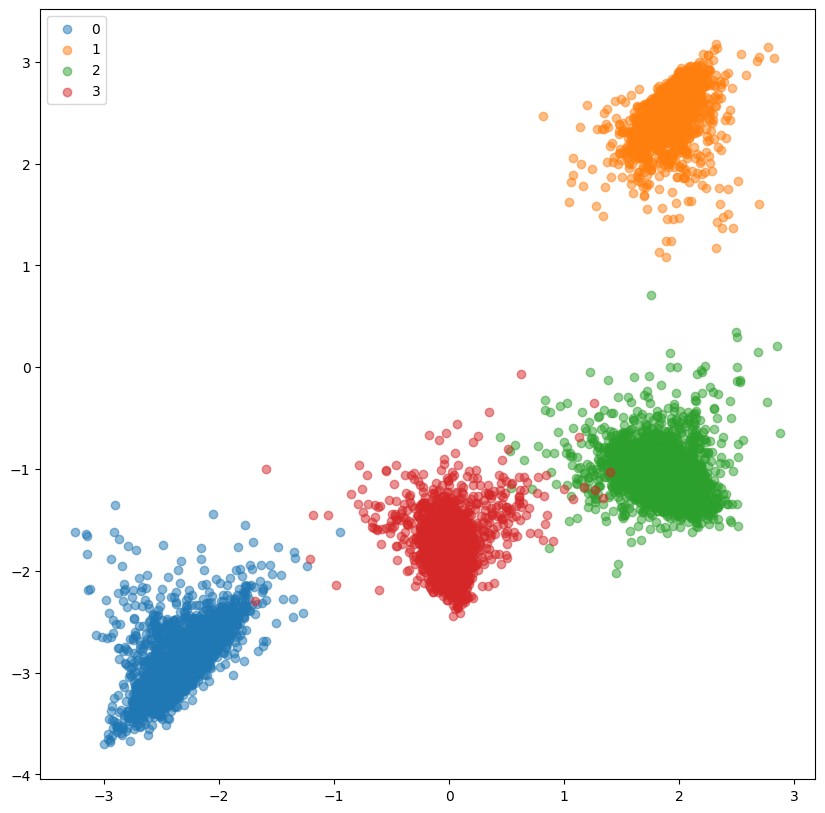

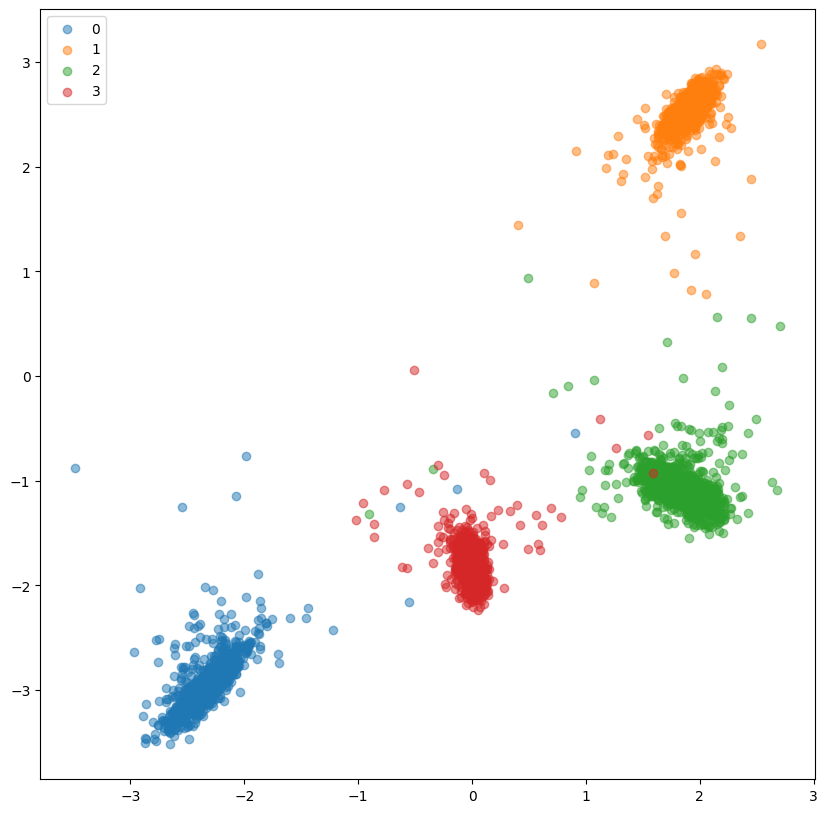

In [57]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair selection

In [58]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=4, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=4, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [59]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.487492
Train: [5000/60000 (8%)]	Loss: 0.275157
Train: [10000/60000 (17%)]	Loss: 0.212242
Train: [15000/60000 (25%)]	Loss: 0.184427
Train: [20000/60000 (33%)]	Loss: 0.160050
Train: [25000/60000 (42%)]	Loss: 0.131216
Train: [30000/60000 (50%)]	Loss: 0.105249
Train: [35000/60000 (58%)]	Loss: 0.092943
Train: [40000/60000 (67%)]	Loss: 0.087194
Train: [45000/60000 (75%)]	Loss: 0.076521
Train: [50000/60000 (83%)]	Loss: 0.070468
Train: [55000/60000 (92%)]	Loss: 0.061356

Epoch: 1/20. Train set: Average loss: 0.1271
Epoch: 1/20. Validation set: Average loss: 0.0617
Train: [0/60000 (0%)]	Loss: 0.062463
Train: [5000/60000 (8%)]	Loss: 0.058093
Train: [10000/60000 (17%)]	Loss: 0.049760
Train: [15000/60000 (25%)]	Loss: 0.045176
Train: [20000/60000 (33%)]	Loss: 0.043344
Train: [25000/60000 (42%)]	Loss: 0.043040
Train: [30000/60000 (50%)]	Loss: 0.040188
Train: [35000/60000 (58%)]	Loss: 0.037742
Train: [40000/60000 (67%)]	Loss: 0.035725
Train: [45000/60000 (75%)]	Loss: 0.0


Epoch: 14/20. Train set: Average loss: 0.0009
Epoch: 14/20. Validation set: Average loss: 0.0103
Train: [0/60000 (0%)]	Loss: 0.000361
Train: [5000/60000 (8%)]	Loss: 0.000626
Train: [10000/60000 (17%)]	Loss: 0.000460
Train: [15000/60000 (25%)]	Loss: 0.000866
Train: [20000/60000 (33%)]	Loss: 0.001692
Train: [25000/60000 (42%)]	Loss: 0.001296
Train: [30000/60000 (50%)]	Loss: 0.001007
Train: [35000/60000 (58%)]	Loss: 0.001247
Train: [40000/60000 (67%)]	Loss: 0.000800
Train: [45000/60000 (75%)]	Loss: 0.000427
Train: [50000/60000 (83%)]	Loss: 0.000457
Train: [55000/60000 (92%)]	Loss: 0.000538

Epoch: 15/20. Train set: Average loss: 0.0008
Epoch: 15/20. Validation set: Average loss: 0.0111
Train: [0/60000 (0%)]	Loss: 0.000375
Train: [5000/60000 (8%)]	Loss: 0.000771
Train: [10000/60000 (17%)]	Loss: 0.000537
Train: [15000/60000 (25%)]	Loss: 0.001143
Train: [20000/60000 (33%)]	Loss: 0.000471
Train: [25000/60000 (42%)]	Loss: 0.001410
Train: [30000/60000 (50%)]	Loss: 0.000417
Train: [35000/60000 

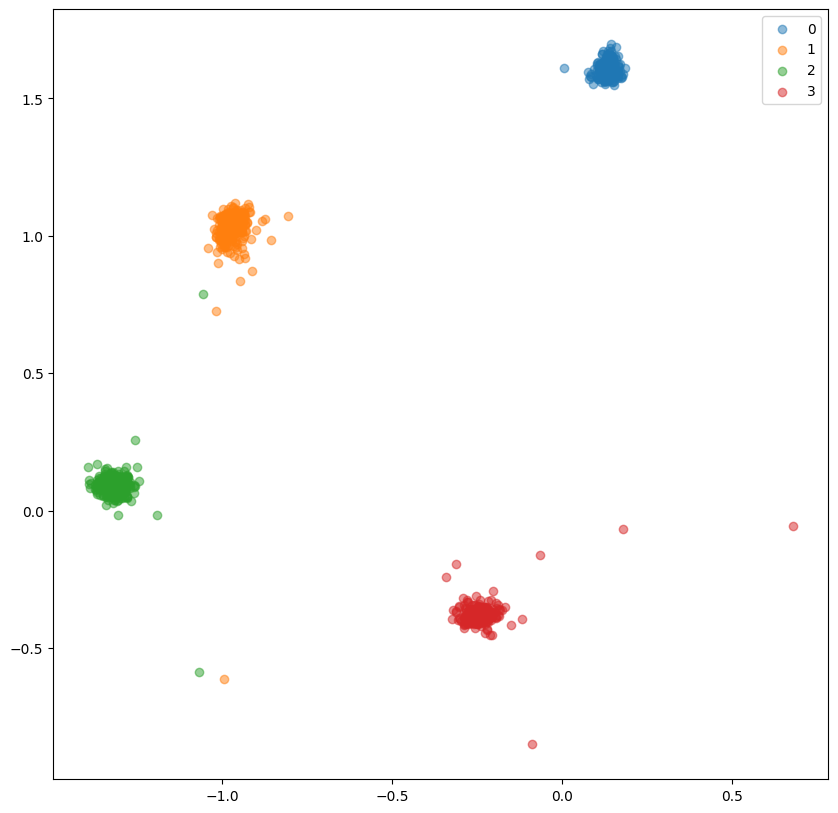

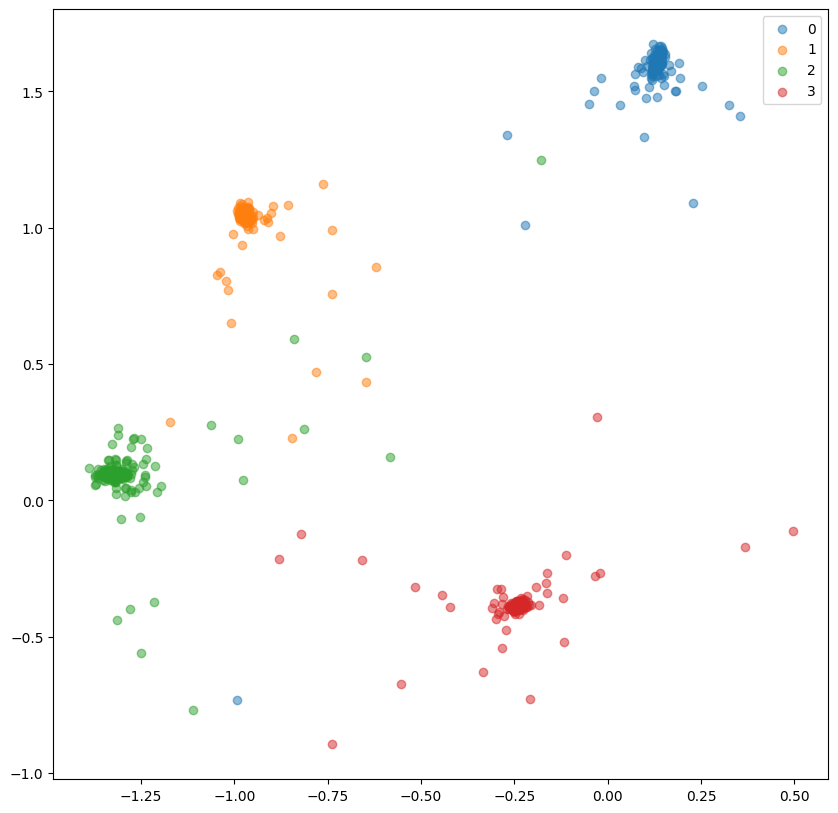

In [60]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

# Online triplet selection

In [61]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=4, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=4, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [62]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999581	Average nonzero triplets: 1200.0
Train: [5000/60000 (8%)]	Loss: 1.057915	Average nonzero triplets: 1109.8235294117646
Train: [10000/60000 (17%)]	Loss: 0.988417	Average nonzero triplets: 1015.8316831683169
Train: [15000/60000 (25%)]	Loss: 1.058962	Average nonzero triplets: 950.9072847682119
Train: [20000/60000 (33%)]	Loss: 1.033417	Average nonzero triplets: 894.8308457711443
Train: [25000/60000 (42%)]	Loss: 0.991389	Average nonzero triplets: 843.3585657370518
Train: [30000/60000 (50%)]	Loss: 1.010505	Average nonzero triplets: 811.1362126245847
Train: [35000/60000 (58%)]	Loss: 1.041611	Average nonzero triplets: 780.2393162393163
Train: [40000/60000 (67%)]	Loss: 1.070182	Average nonzero triplets: 757.3241895261846
Train: [45000/60000 (75%)]	Loss: 1.017653	Average nonzero triplets: 737.529933481153
Train: [50000/60000 (83%)]	Loss: 1.155640	Average nonzero triplets: 715.6966067864272
Train: [55000/60000 (92%)]	Loss: 0.947225	Average nonzero triplets: 696


Epoch: 7/20. Train set: Average loss: 1.0779	Average nonzero triplets: 120.2220367278798
Epoch: 7/20. Validation set: Average loss: 1.4334	Average nonzero triplets: 199.41414141414143
Train: [0/60000 (0%)]	Loss: 0.293406	Average nonzero triplets: 303.0
Train: [5000/60000 (8%)]	Loss: 0.993397	Average nonzero triplets: 152.45098039215685
Train: [10000/60000 (17%)]	Loss: 0.976745	Average nonzero triplets: 139.26732673267327
Train: [15000/60000 (25%)]	Loss: 0.680790	Average nonzero triplets: 123.70198675496688
Train: [20000/60000 (33%)]	Loss: 0.823766	Average nonzero triplets: 105.75124378109453
Train: [25000/60000 (42%)]	Loss: 0.931647	Average nonzero triplets: 98.62948207171314
Train: [30000/60000 (50%)]	Loss: 0.647918	Average nonzero triplets: 96.29235880398672
Train: [35000/60000 (58%)]	Loss: 0.808204	Average nonzero triplets: 91.97435897435898
Train: [40000/60000 (67%)]	Loss: 0.555864	Average nonzero triplets: 84.45386533665835
Train: [45000/60000 (75%)]	Loss: 0.408909	Average nonzer

Train: [50000/60000 (83%)]	Loss: 0.222032	Average nonzero triplets: 20.964071856287426
Train: [55000/60000 (92%)]	Loss: 0.196264	Average nonzero triplets: 22.234119782214155

Epoch: 14/20. Train set: Average loss: 0.2348	Average nonzero triplets: 22.52754590984975
Epoch: 14/20. Validation set: Average loss: 0.8045	Average nonzero triplets: 69.38383838383838
Train: [0/60000 (0%)]	Loss: 0.443448	Average nonzero triplets: 10.0
Train: [5000/60000 (8%)]	Loss: 0.137091	Average nonzero triplets: 20.54901960784314
Train: [10000/60000 (17%)]	Loss: 0.539798	Average nonzero triplets: 20.85148514851485
Train: [15000/60000 (25%)]	Loss: 0.279246	Average nonzero triplets: 24.70198675496689
Train: [20000/60000 (33%)]	Loss: 0.305824	Average nonzero triplets: 23.28855721393035
Train: [25000/60000 (42%)]	Loss: 0.123716	Average nonzero triplets: 19.888446215139442
Train: [30000/60000 (50%)]	Loss: 0.120064	Average nonzero triplets: 17.186046511627907
Train: [35000/60000 (58%)]	Loss: 0.322517	Average nonzer

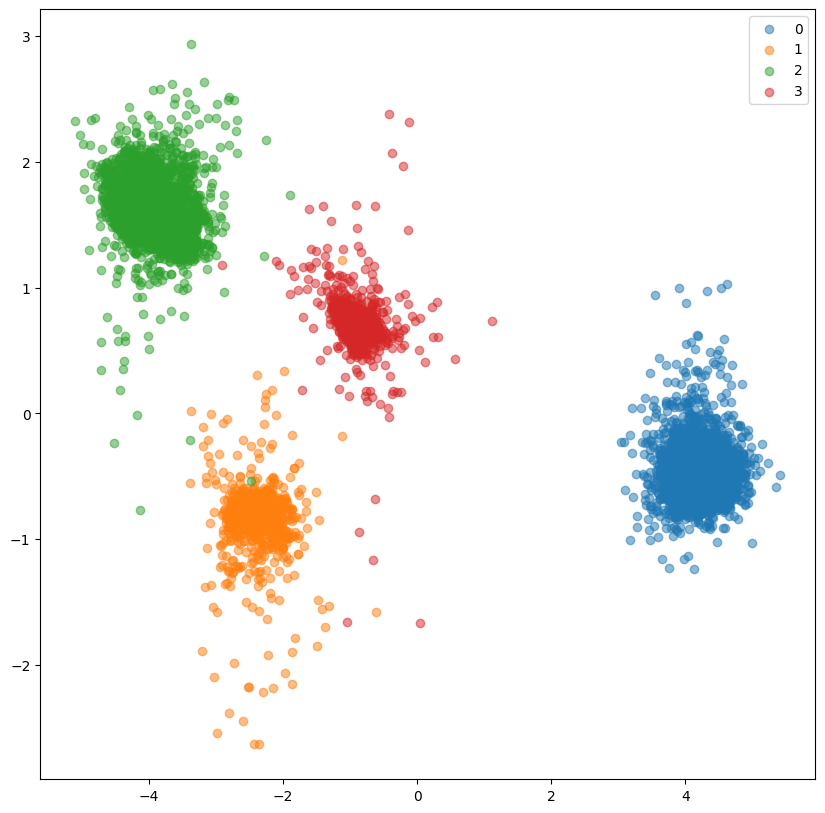

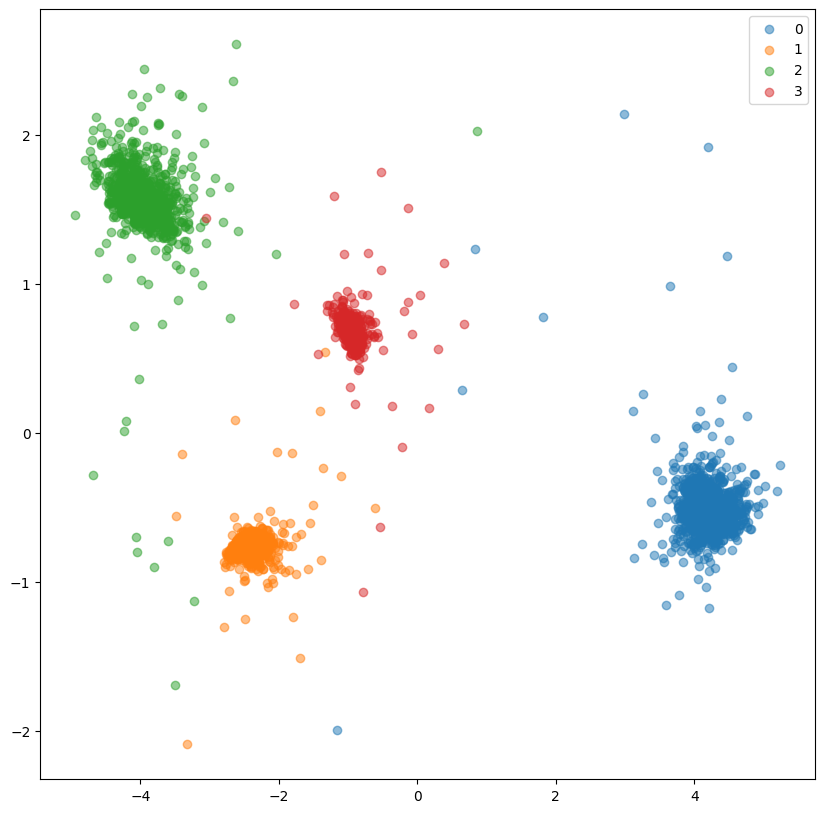

In [63]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

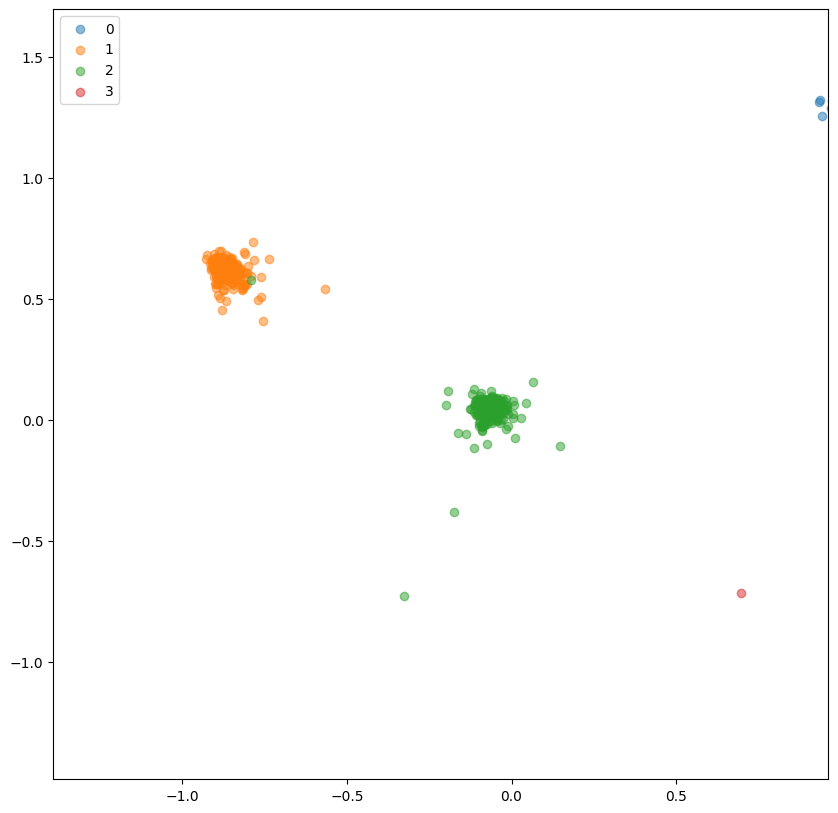

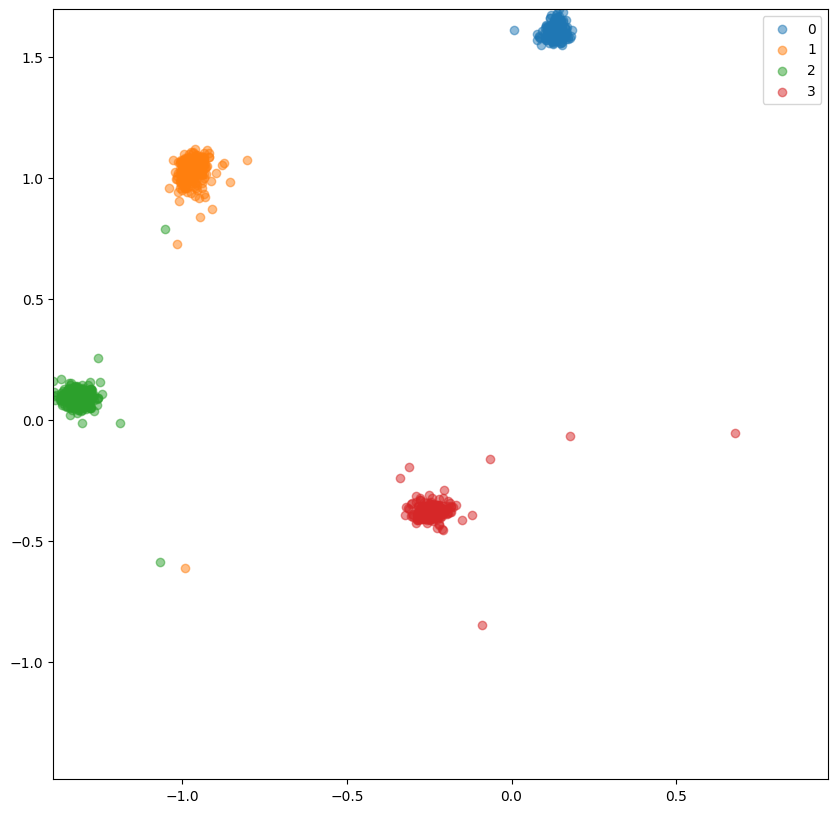

In [64]:
x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)